In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, precision_recall_curve


In [13]:
#DATASET
train = pd.read_csv("/content/drive/MyDrive/dataset (1)/train.csv")
test = pd.read_csv("/content/drive/MyDrive/dataset (1)/test.csv")
train
test

,company_id,company_name,industry,funding_rounds,total_funding,last_funding_date,job_postings_30d,employee_growth_pct,hiring_roles,industry_growth_rate,regional_employment_trend,funding_per_employee,days_since_last_funding,growth_momentum,is_hot_lead
0,COMP_004135,Bullock Group,Retail,3.265246,2425223.28,2021-08-20,7.201083,5.569041,Operations,8.0,8.4,3566.504824,1280,1.697656e+07,0
1,COMP_011804,"Morris, Tyler and Scott",SaaS,1.912502,3988620.41,2020-05-28,14.562457,46.348625,Engineering,7.1,4.3,890.317056,1729,5.584069e+07,1
2,COMP_021637,Lara-Williams,Tech,5.425373,2645234.46,2021-03-04,14.797940,34.121940,Marketing,16.0,14.8,669.679610,1449,3.703328e+07,0
3,COMP_018533,Frost-Hernandez,Retail,0.987882,3194492.15,2022-10-25,14.946632,4.969312,Sales,21.1,5.9,5414.393475,849,4.152840e+07,0
4,COMP_014125,Williams-Bean,Retail,3.583654,884497.73,2020-11-01,9.714369,-7.111839,Operations,8.1,-4.3,-1499.148695,1572,9.729475e+06,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,COMP_012325,Murray Inc,Fintech,3.447588,7273814.38,2021-12-26,20.262727,3.601031,Sales,9.6,-0.8,13988.104577,1152,1.454763e+08,0
4996,COMP_017779,Fernandez LLC,Tech,2.818313,3748213.74,2020-10-26,5.931160,45.109600,Marketing,6.2,-4.5,804.337712,1578,1.874107e+07,0
4997,COMP_008514,Salas Inc,SaaS,2.177181,8352240.36,2020-11-22,14.886280,35.110038,Marketing,25.4,10.9,2163.792839,1551,1.252836e+08,1
4998,COMP_020714,Brooks Inc,Healthcare,0.741923,8748941.69,2021-09-24,11.137551,46.251968,Operations,9.3,-2.1,1792.815920,1245,8.748942e+07,0


In [14]:
#DATA CLEANING
drop_cols = ["company_id", "company_name", "last_funding_date"]
train = train.drop(columns=drop_cols)
test_ids = test["company_id"]
test = test.drop(columns=drop_cols)

#ENCODING
label_encoders = {}
for col in ["industry", "hiring_roles"]:
    le = LabelEncoder()
    train[col] = le.fit_transform(train[col])
    test[col] = le.transform(test[col])
    label_encoders[col] = le

X = train.drop(columns=["is_hot_lead"])
y = train["is_hot_lead"]

X.replace([np.inf, -np.inf], np.nan, inplace=True)
X.fillna(X.median(), inplace=True)

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


<ipython-input-7-9e2a003a4abc>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y, palette="coolwarm")


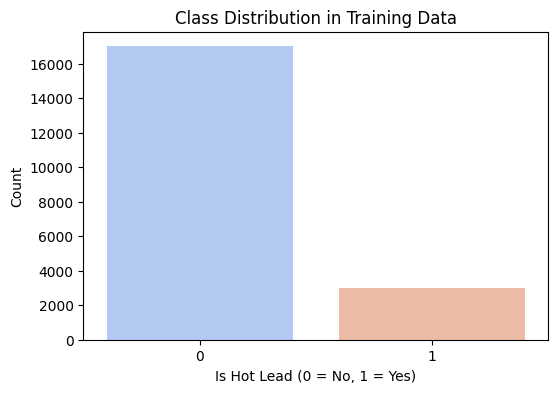

In [7]:
# Class Distribution Plot
plt.figure(figsize=(6, 4))
sns.countplot(x=y, palette="coolwarm")
plt.title("Class Distribution in Training Data")
plt.xlabel("Is Hot Lead (0 = No, 1 = Yes)")
plt.ylabel("Count")
plt.show()


<Figure size 1000x600 with 0 Axes>

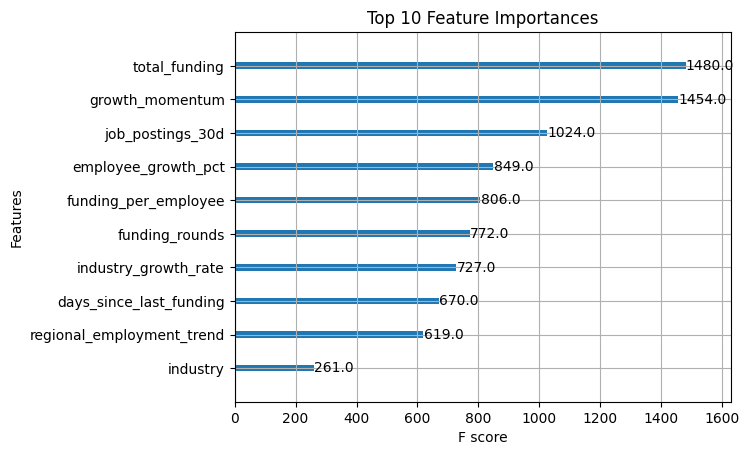

In [6]:
# Feature Importance Plot
plt.figure(figsize=(10, 6))
xgb.plot_importance(model, importance_type="weight", max_num_features=10)
plt.title("Top 10 Feature Importances")
plt.show()

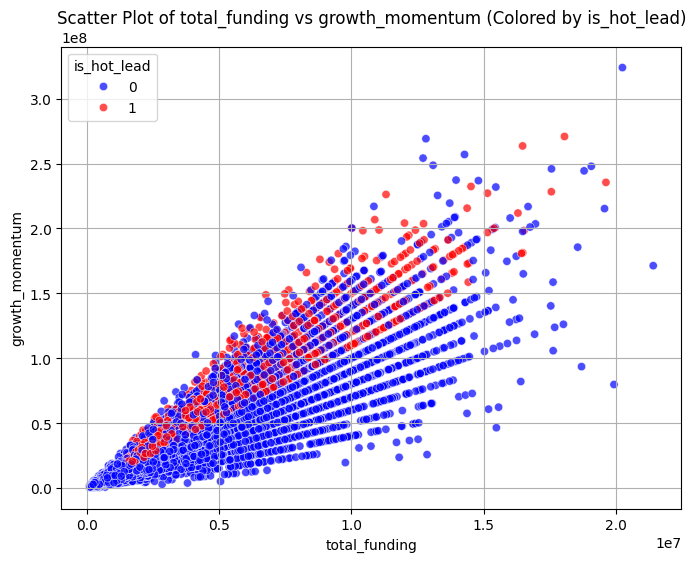

In [8]:
feature_x = "total_funding"
feature_y = "growth_momentum"

# Scatter plot
plt.figure(figsize=(8, 6))
sns.scatterplot(
    x=X_train[feature_x],
    y=X_train[feature_y],
    hue=y_train,  # Color by target variable
    palette=["blue", "red"],  # 0 -> Blue, 1 -> Red
    alpha=0.7
)

plt.xlabel(feature_x)
plt.ylabel(feature_y)
plt.title(f"Scatter Plot of {feature_x} vs {feature_y} (Colored by is_hot_lead)")
plt.legend(title="is_hot_lead")
plt.grid()
plt.show()



In [15]:
print("Before Resampling:")
print(y_train.value_counts())

#SMOTE
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

print("\nAfter Resampling:")
print(y_train_resampled.value_counts())

dtrain = xgb.DMatrix(X_train_resampled, label=y_train_resampled)
dval = xgb.DMatrix(X_val, label=y_val)

params = {"objective": "binary:logistic", "eval_metric": "logloss", "learning_rate": 0.05, "max_depth": 6, "subsample": 0.8, "colsample_bytree": 0.8, "random_state": 42,}

model = xgb.train(params=params, dtrain=dtrain, num_boost_round=300, evals=[(dval, "validation")], early_stopping_rounds=20, verbose_eval=True)

y_pred_prob = model.predict(dval)
y_pred = (y_pred_prob > 0.5).astype(int)

acc = accuracy_score(y_val, y_pred)
preci = precision_score(y_val, y_pred)
recall = recall_score(y_val, y_pred)
f1 = f1_score(y_val, y_pred)
conf_matrix = confusion_matrix(y_val, y_pred)

print(f"\nAccuracy: {acc:.4f}")
print(f"Precision: {preci:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")
print("Confusion Matrix:")
print(conf_matrix)

if "is_hot_lead" in test.columns:
    test = test.drop(columns=["is_hot_lead"])

test.replace([np.inf, -np.inf], np.nan, inplace=True)
test.fillna(test.median(), inplace=True)

dtest = xgb.DMatrix(test)

# Submission
test_predictions = (model.predict(dtest) > 0.5).astype(int)

submission = pd.DataFrame({"company_id": test_ids, "is_hot_lead": test_predictions})
submission.to_csv("submission.csv", index=False)

print("\n Submission file saved as submission.csv")


Before Resampling:
is_hot_lead
0    13612
1     2388
Name: count, dtype: int64

After Resampling:
is_hot_lead
0    13612
1    13612
Name: count, dtype: int64
[0]	validation-logloss:0.65227
[1]	validation-logloss:0.61514
[2]	validation-logloss:0.58186
[3]	validation-logloss:0.55581
[4]	validation-logloss:0.52873
[5]	validation-logloss:0.50536
[6]	validation-logloss:0.48702
[7]	validation-logloss:0.46437
[8]	validation-logloss:0.44914
[9]	validation-logloss:0.43095
[10]	validation-logloss:0.41769
[11]	validation-logloss:0.40483
[12]	validation-logloss:0.39329
[13]	validation-logloss:0.37750
[14]	validation-logloss:0.36439
[15]	validation-logloss:0.35193
[16]	validation-logloss:0.33924
[17]	validation-logloss:0.32790
[18]	validation-logloss:0.31808
[19]	validation-logloss:0.30870
[20]	validation-logloss:0.30020
[21]	validation-logloss:0.29091
[22]	validation-logloss:0.28524
[23]	validation-logloss:0.27909
[24]	validation-logloss:0.27116
[25]	validation-logloss:0.26644
[26]	validation-logl

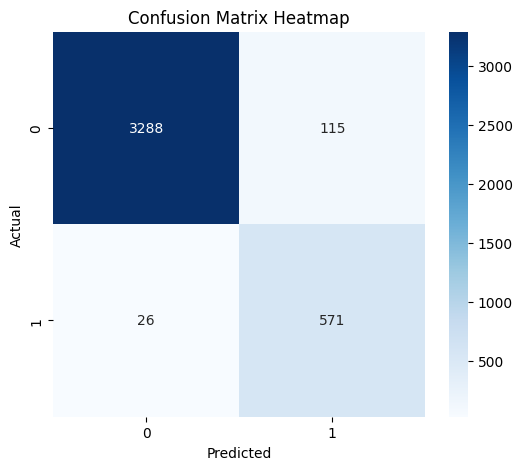

In [5]:
# Confusion Matrix Heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=[0, 1], yticklabels=[0, 1])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix Heatmap")
plt.show()

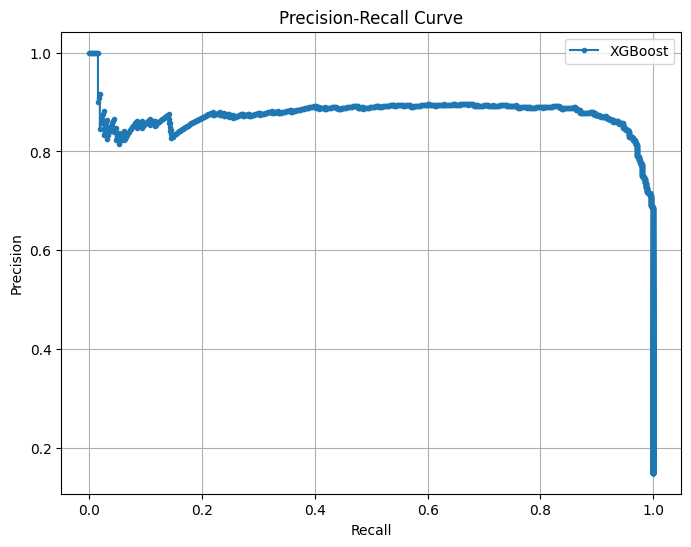

In [4]:
# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_val, y_pred_prob)
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, marker='.', label='XGBoost')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid()
plt.show()